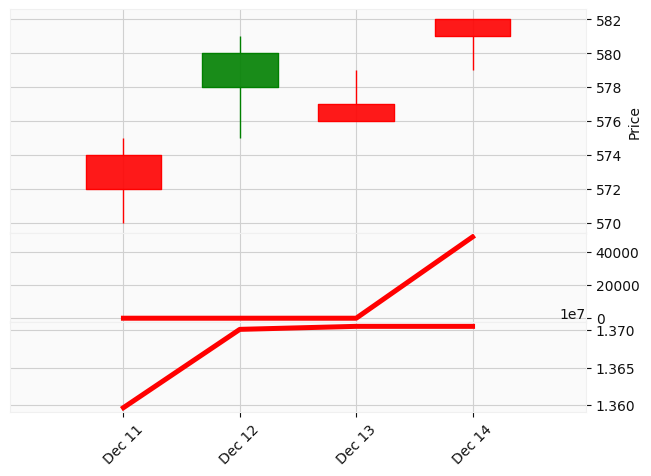

In [1]:
# 載入必要套件
from BackTest import ChartTrade
import mplfinance as mpf
import pandas as pd
import os
import yfinance as yf


# 設置基本路徑：臨時先設置為 data
datapath = './'


# (3)取得融券借券 證交所資料來源
def getTSEShortSales(prod, st, en):
    # 備份檔名：暫時先存放在 data
    bakfile = f"{datapath}/{prod}_{st}_{en}_TSE_ShortSales.csv"
    # 假如資料檔案不存在
    if not os.path.exists(bakfile):
        # 取得檔案內容
        tmpdata = pd.read_csv("融券借券爬蟲資料.csv", encoding="utf-8")
        '''
        ['代號', '名稱', '前日餘額', '賣出', '買進', '現券', '今日餘額',
        '限額', '前日餘額.1', '當日賣出', '當日還券', '當日調整', '當日餘額',
        '次一營業日可限額', '備註', '日期']
        '''
        # 修改日期格式
        tmpdata["日期"] = pd.to_datetime(tmpdata["日期"].astype(str), format="%Y%m%d")
        # 使用正确的日期比较
        tmpdata = tmpdata.query("`代號` == @prod and @st <= `日期` <= @en").copy()
        #
        tmpdata["日期"] = pd.to_datetime(tmpdata["日期"], format="%Y%m%d")
        # 將日期設為索引
        tmpdata.set_index('日期', inplace=True)
        # 將 DataFrame 的索引名稱改為小寫
        tmpdata.index.name = tmpdata.index.name.lower()
        # 將資料內容轉換為數值
        for col in tmpdata.columns[2:-1]:
            # 檢查列中的數據類型，如果是 'object' 則嘗試轉換
            if tmpdata[col].dtype == 'object':
                tmpdata[col] = tmpdata[col].str.replace(",", "")
                tmpdata[col] = pd.to_numeric(tmpdata[col], errors='coerce').fillna(0).astype(int)
            else:
                tmpdata[col] = tmpdata[col].astype(int)
        # 將單一證券內容寫入備份檔中
        tmpdata.to_csv(bakfile, index_label='日期')
    # 幾如檔案已經存在
    else:
        # 取得檔案內容
        tmpdata = pd.read_csv(bakfile)
        tmpdata["日期"] = pd.to_datetime(tmpdata["日期"])
        tmpdata = tmpdata.set_index(tmpdata["日期"])
        tmpdata.drop("日期", axis=1, inplace=True)

    # 回傳資料
    tmpdata.columns = [
        "證券代號",
        "股票名稱",
        "融券前日餘額",
        "融券賣出",
        "融券買進",
        "融券現券",
        "融券今日餘額",
        "融券限額",
        "借券前日餘額",
        "借券當日賣出",
        "借券當日還券",
        "借券當日調整",
        "借券當日餘額",
        "次一營業日可限額",
        "備註",
    ]
    return tmpdata


# (2)更新資料源為： Yahoo Finance
def getDataFM(prod, st, en):
    # 檔案路徑
    bakfile = f"data/YF_{prod}_{st}_{en}_stock_daily_adj.csv"
    # 假如已經有 Excel 資料檔案
    if os.path.exists(bakfile):
        # 讀取 Excel 資料檔案
        data = pd.read_csv(bakfile, index_col="Date", parse_dates=True)
    # 假如 Excel 資料檔案不存在
    else:
        # 透過 yf 下載
        data = yf.download(f"{prod}.TW", start=st, end=en)
        # 下載的資料是英文的，處理欄位名稱，轉換為小寫
        # 轉換部分不包含索引，所以日期還是大寫開頭的 Date
        data.columns = [i.lower() for i in data.columns]
        # 假如下載後沒有資料
        if data.empty:
            print("無法從 Yahoo Finance 下載資料")
            # 傳回一個空的 pd
            return pd.DataFrame()
        # 假如資料 data 不是空的，依照指定路徑存擋
        data.to_csv(bakfile)
    # 存檔後，傳回資料
    return data


# (1)取得股價以及融券借券：證交所資料來源
def getTSEPriceAndShortSales(prod, st, en):
    # 取得資料，假如有內容的話，同時也會存成預設的檔案
    data1 = getDataFM(prod, st, en)
    # 轉換日期：假如日期參數有使用-，就取消
    st = st.replace("-", "")
    en = en.replace("-", "")
    # 取得證交所的融券借券
    data2 = getTSEShortSales(prod, st, en)
    data3 = pd.concat([data1, data2], axis=1, join="inner")
    return data3


if __name__ == "__main__":
    # 指定程式碼
    prod = "2330"
    # 取得回測資料
    data = getTSEPriceAndShortSales(prod, "2023-12-01", "2023-12-15")

    # 融券借券餘額
    data["融券今日餘額"] = data["融券今日餘額"].astype(int)
    data["借券當日餘額"] = data["借券當日餘額"].astype(int)

    # 繪製副圖
    addp = []
    # 融券借券
    addp.append(mpf.make_addplot(data["融券今日餘額"], panel=1, color="red", secondary_y=False))
    addp.append(mpf.make_addplot(data["借券當日餘額"], panel=2, color="red", secondary_y=False))

    # 繪製K線圖與交易明細
    ChartTrade(data, addp=addp, v_enable=False)
